In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

In [2]:
from pyspark.sql.functions import when, count, col, log, avg, array, explode, struct, lit
from pyspark.sql.types import StructField,StringType,IntegerType,StructType

from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer,Normalizer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Understanding

## Collect the Data

In [3]:
# Use Spark to read csv file
SuicideStats = spark.read.csv("data/who_suicide_statistics.csv",inferSchema=True,header=True)

HDIStats = spark.read.csv("data/Human Development Index.csv",inferSchema=True,header=True)

WDIStats = spark.read.csv("data/World_Development_Indicators.csv",inferSchema=True,header=True)

## Describe the Data

In [4]:
#Explore the volumn of the dataset WHO Suicide Statistics
print((SuicideStats.count(), len(SuicideStats.columns)))

(43776, 6)


In [5]:
#Explore the volumn of the dataset Human Development Index
print((HDIStats.count(), len(HDIStats.columns)))

(189, 31)


In [6]:
#Explore the volumn of the dataset World Development Indicators
print((WDIStats.count(), len(WDIStats.columns)))

(6944, 6)


In [7]:
#Explore the data quality of the dataset WHO Suicide Statistics
print(SuicideStats.columns)
SuicideStats.show(6)

['country', 'year', 'sex', 'age', 'suicides_no', 'population']
+-------+----+------+-----------+-----------+----------+
|country|year|   sex|        age|suicides_no|population|
+-------+----+------+-----------+-----------+----------+
|Albania|1985|female|15-24 years|       null|    277900|
|Albania|1985|female|25-34 years|       null|    246800|
|Albania|1985|female|35-54 years|       null|    267500|
|Albania|1985|female| 5-14 years|       null|    298300|
|Albania|1985|female|55-74 years|       null|    138700|
|Albania|1985|female|  75+ years|       null|     34200|
+-------+----+------+-----------+-----------+----------+
only showing top 6 rows



In [8]:
#Explore the data type of the dataset WHO Suicide Statistics
SuicideStats.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)



In [9]:
SuicideStats.select("sex").distinct().show()
SuicideStats.select("age").distinct().show()
print(SuicideStats.select("country").distinct().count())
SuicideStats.select("country").distinct().show(6)

+------+
|   sex|
+------+
|female|
|  male|
+------+

+-----------+
|        age|
+-----------+
|55-74 years|
|25-34 years|
| 5-14 years|
|  75+ years|
|15-24 years|
|35-54 years|
+-----------+

141
+-----------------+
|          country|
+-----------------+
|         Anguilla|
|         Paraguay|
|       Cabo Verde|
|           Sweden|
|         Kiribati|
|Republic of Korea|
+-----------------+
only showing top 6 rows



In [10]:
#Explore the general statistics of the dataset WHO Suicide Statistics
SuicideStats.describe().show()

+-------+--------+------------------+------+-----------+-----------------+------------------+
|summary| country|              year|   sex|        age|      suicides_no|        population|
+-------+--------+------------------+------+-----------+-----------------+------------------+
|  count|   43776|             43776| 43776|      43776|            41520|             38316|
|   mean|    null|1998.5024671052631|  null|       null|193.3153901734104|1664091.1353742562|
| stddev|    null|10.338711176746282|  null|       null|800.5899259349637|3647231.2274873867|
|    min| Albania|              1979|female|15-24 years|                0|               259|
|    max|Zimbabwe|              2016|  male|  75+ years|            22338|          43805214|
+-------+--------+------------------+------+-----------+-----------------+------------------+



In [11]:
#Explore the data quality of the dataset Human Development Index
print(HDIStats.columns)
HDIStats.show(6)

['HDI Rank', 'Country', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
+--------+-----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|HDI Rank|          Country| 1990| 1991| 1992| 1993| 1994| 1995| 1996| 1997| 1998| 1999| 2000| 2001| 2002| 2003| 2004| 2005| 2006| 2007| 2008| 2009| 2010| 2011| 2012| 2013| 2014| 2015| 2016| 2017| 2018|
+--------+-----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|     170|      Afghanistan|0.298|0.304|0.312|0.308|0.303|0.327|0.331|0.335|0.339|0.343|0.345|0.347|0.378|0.387|  0.4| 0.41|0.419|0.431

In [12]:
#Explore the data type of the dataset Human Development Index
HDIStats.printSchema()

root
 |-- HDI Rank: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- 1990: string (nullable = true)
 |-- 1991: string (nullable = true)
 |-- 1992: string (nullable = true)
 |-- 1993: string (nullable = true)
 |-- 1994: string (nullable = true)
 |-- 1995: string (nullable = true)
 |-- 1996: string (nullable = true)
 |-- 1997: string (nullable = true)
 |-- 1998: string (nullable = true)
 |-- 1999: string (nullable = true)
 |-- 2000: string (nullable = true)
 |-- 2001: string (nullable = true)
 |-- 2002: string (nullable = true)
 |-- 2003: string (nullable = true)
 |-- 2004: string (nullable = true)
 |-- 2005: string (nullable = true)
 |-- 2006: string (nullable = true)
 |-- 2007: string (nullable = true)
 |-- 2008: string (nullable = true)
 |-- 2009: string (nullable = true)
 |-- 2010: string (nullable = true)
 |-- 2011: string (nullable = true)
 |-- 2012: string (nullable = true)
 |-- 2013: string (nullable = true)
 |-- 2014: string (nullable = true)
 |-- 2015: stri

In [13]:
#Explore the general statistics of the dataset Human Development Index
HDIStats.describe().show()

+-------+-----------------+-----------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+
|summary|         HDI Rank|    Country|               1990|              1991|               1992|               1993|               1994|              1995|               1996|              1997|              1998|             1999|               2000|               2001|               2002|              2003|               2004|               2005|              2006|               2007|

In [14]:
#Explore the data quality of the dataset World Development Indicators
print(WDIStats.columns)
WDIStats.show(6)

['Country Name', 'Year', 'Employment to population ratio', 'GDP', 'GDP per capita', 'Gini index']
+------------+----+------------------------------+----+--------------+----------+
|Country Name|Year|Employment to population ratio| GDP|GDP per capita|Gini index|
+------------+----+------------------------------+----+--------------+----------+
| Afghanistan|1985|                          null|null|          null|      null|
| Afghanistan|1986|                          null|null|          null|      null|
| Afghanistan|1987|                          null|null|          null|      null|
| Afghanistan|1988|                          null|null|          null|      null|
| Afghanistan|1989|                          null|null|          null|      null|
| Afghanistan|1990|                          null|null|          null|      null|
+------------+----+------------------------------+----+--------------+----------+
only showing top 6 rows



In [15]:
#Explore the data type of the dataset World Development Indicators
WDIStats.printSchema()

root
 |-- Country Name: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Employment to population ratio: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- GDP per capita: double (nullable = true)
 |-- Gini index: double (nullable = true)



In [16]:
#Explore the general statistics of the dataset World Development Indicators
WDIStats.describe().show()

+-------+------------+-----------------+------------------------------+--------------------+------------------+-----------------+
|summary|Country Name|             Year|Employment to population ratio|                 GDP|    GDP per capita|       Gini index|
+-------+------------+-----------------+------------------------------+--------------------+------------------+-----------------+
|  count|        6944|             6944|                          4862|                5979|              5976|             1550|
|   mean|        null|           2000.5|              57.6225362242226|2.745890309848958...| 13124.04119241654|38.62148387096775|
| stddev|        null|9.233757553344075|            11.968146617150545|1.111967617317697E12|20099.670239668914|9.432100956926329|
|    min| Afghanistan|             1985|                   26.32999992|       2.144196696E7|       164.1918663|             20.2|
|    max|    Zimbabwe|             2016|                    90.4469986|          1.69723E1

##Verify the Data Quality

In [17]:
#Explore missing values in the dataset WHO Suicide Statistics

SuicideStats.select([count(when(col(c).isNull(), c)).alias(c) for c in SuicideStats.columns]).show()
SuicideStats.describe().filter(col("summary")  == "count").show()

+-------+----+---+---+-----------+----------+
|country|year|sex|age|suicides_no|population|
+-------+----+---+---+-----------+----------+
|      0|   0|  0|  0|       2256|      5460|
+-------+----+---+---+-----------+----------+

+-------+-------+-----+-----+-----+-----------+----------+
|summary|country| year|  sex|  age|suicides_no|population|
+-------+-------+-----+-----+-----+-----------+----------+
|  count|  43776|43776|43776|43776|      41520|     38316|
+-------+-------+-----+-----+-----+-----------+----------+



In [18]:
#Re-import dataset, taking .. as null value
HDIStats = spark.read.csv("data/Human Development Index.csv",inferSchema=True, header=True, nullValue="..")

#Explore missing values in the dataset World Development Indicators
HDIStats.select([count(when(col(c).isNull(), c)).alias(c) for c in HDIStats.columns]).show()
HDIStats.describe().filter(col("summary")  == "count").show()

+--------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|HDI Rank|Country|1990|1991|1992|1993|1994|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|
+--------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|       0|      0|  45|  45|  46|  45|  45|  41|  41|  42|  41|  38|  15|  15|  14|  12|  10|   3|   3|   3|   3|   3|   1|   1|   1|   1|   1|   1|   1|   0|   0|
+--------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+

+-------+--------+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|summar

In [19]:
#Explore missing values in the dataset World Development Indicators
WDIStats.select([count(when(col(c).isNull(), c)).alias(c) for c in WDIStats.columns]).show()
WDIStats.describe().filter(col("summary")  == "count").show()

+------------+----+------------------------------+---+--------------+----------+
|Country Name|Year|Employment to population ratio|GDP|GDP per capita|Gini index|
+------------+----+------------------------------+---+--------------+----------+
|           0|   0|                          2082|965|           968|      5394|
+------------+----+------------------------------+---+--------------+----------+

+-------+------------+----+------------------------------+----+--------------+----------+
|summary|Country Name|Year|Employment to population ratio| GDP|GDP per capita|Gini index|
+-------+------------+----+------------------------------+----+--------------+----------+
|  count|        6944|6944|                          4862|5979|          5976|      1550|
+-------+------------+----+------------------------------+----+--------------+----------+



# Data Preparation

## Select the Data

In [20]:
#Selecting Items
#select records with populartion greater than 0
print((SuicideStats.count(), len(SuicideStats.columns)))

SuicideStats.createOrReplaceTempView('suicideStats')
SuicideStats = spark.sql("SELECT * FROM suicideStats WHERE population >= 0")
print((SuicideStats.count(), len(SuicideStats.columns)))

(43776, 6)
(38316, 6)


In [21]:
#remove HDI Rank from HDIStats
print((HDIStats.count(), len(HDIStats.columns)))

HDIStats = HDIStats.drop("HDI Rank")

print((HDIStats.count(), len(HDIStats.columns)))

(189, 31)
(189, 30)


In [22]:
HDIStats.show(6)

+-----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|          Country| 1990| 1991| 1992| 1993| 1994| 1995| 1996| 1997| 1998| 1999| 2000| 2001| 2002| 2003| 2004| 2005| 2006| 2007| 2008| 2009| 2010| 2011| 2012| 2013| 2014| 2015| 2016| 2017| 2018|
+-----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|      Afghanistan|0.298|0.304|0.312|0.308|0.303|0.327|0.331|0.335|0.339|0.343|0.345|0.347|0.378|0.387|  0.4| 0.41|0.419|0.431|0.436|0.447|0.464|0.465|0.479|0.485|0.488| 0.49|0.491|0.493|0.496|
|          Albania|0.644|0.625|0.608|0.611|0.617|0.629|0.639|0.639|0.649| 0.66|0.667|0.673| 0.68|0.687|0.692|0.702|0.709|0.718|0.724|0.729| 0.74|0.759|0.771|0.781|0.787|0.788|0.788|0.789|0.791|
|          Algeria|0.578|0.582

## Clean the Data

In [23]:
#Data cleaning
#remove misssing values from WHO Suicide Statistics
print((SuicideStats.count(), len(SuicideStats.columns)))
SuicideStats = SuicideStats.na.drop(subset="suicides_no")
print((SuicideStats.count(), len(SuicideStats.columns)))

#Display the number of null value in each column after removing missing values
SuicideStats.select([count(when(col(c).isNull(), c)).alias(c) for c in SuicideStats.columns]).show()

(38316, 6)
(36060, 6)
+-------+----+---+---+-----------+----------+
|country|year|sex|age|suicides_no|population|
+-------+----+---+---+-----------+----------+
|      0|   0|  0|  0|          0|         0|
+-------+----+---+---+-----------+----------+



In [24]:
#Calculate mean value of each country
HDIStatsMean = HDIStats.na.fill(0)
HDIStatsMean = HDIStatsMean.select(col('Country'), (sum(col(x) for x in HDIStats.columns[1:]) / len(HDIStats.columns)-1).alias("mean"))

HDIStatsMean.show(6)

+-----------------+--------------------+
|          Country|                mean|
+-----------------+--------------------+
|      Afghanistan| -0.6149666666666667|
|          Albania|-0.32346666666666657|
|          Algeria|              -0.346|
|          Andorra| -0.4764666666666667|
|           Angola| -0.6722333333333333|
|AntiguaandBarbuda|             -0.6392|
+-----------------+--------------------+
only showing top 6 rows



In [25]:
HDIStats = HDIStats.alias('a')\
    .join(HDIStatsMean.alias('b'),col('b.Country') == col('a.Country'))\
    .select([when(col('a.'+xx).isNull(), col('b.mean')).otherwise(col('a.'+xx)).alias(xx) for xx in HDIStats.columns])

#Display the number of null value in each column after removing missing values
HDIStats.select([count(when(col(c).isNull(), c)).alias(c) for c in HDIStats.columns]).show()


+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|Country|1990|1991|1992|1993|1994|1995|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|
+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|      0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+



In [26]:
#cleanig WDIStats
#replace missing value with the mean value of this country

WDIStats.select([count(when(col(c).isNull(), c)).alias(c) for c in WDIStats.columns]).show()

def fill_with_mean(df, exclude=set()): 
    stats = df.agg(*(
        avg(c).alias(c) for c in df.columns if c not in exclude
    ))
    return df.na.fill(stats.first().asDict())

WDIStats = fill_with_mean(WDIStats, ["Country Name", "Year"])

WDIStats.select([count(when(col(c).isNull(), c)).alias(c) for c in WDIStats.columns]).show()

+------------+----+------------------------------+---+--------------+----------+
|Country Name|Year|Employment to population ratio|GDP|GDP per capita|Gini index|
+------------+----+------------------------------+---+--------------+----------+
|           0|   0|                          2082|965|           968|      5394|
+------------+----+------------------------------+---+--------------+----------+

+------------+----+------------------------------+---+--------------+----------+
|Country Name|Year|Employment to population ratio|GDP|GDP per capita|Gini index|
+------------+----+------------------------------+---+--------------+----------+
|           0|   0|                             0|  0|             0|         0|
+------------+----+------------------------------+---+--------------+----------+



In [27]:
#remove extreme and outliers
print((SuicideStats.count(), len(SuicideStats.columns)))

bounds = {
    c: dict(
        zip(["q1", "q3"], SuicideStats.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in SuicideStats.columns if c in ["suicides_no", "population"]
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)

SuicideStats = SuicideStats.select(
    "*",
    *[
        when(
            col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in SuicideStats.columns  if c in ["suicides_no", "population"]
    ]
)

SuicideStats.createOrReplaceTempView('SuicideStats')
SuicideStats = spark.sql("SELECT country, year, sex, age, suicides_no, population FROM SuicideStats WHERE suicides_no_out = 0 and population_out=0 ")
print((SuicideStats.count(), len(SuicideStats.columns)))


(36060, 6)
(28783, 6)


## Construct the Data

In [28]:
#Construct the Data
#add new feature suicidePer100k to SuicideStats

SuicideStats = SuicideStats.withColumn("SuicidePer100k", col("suicides_no")/col("population")*100000)

print((SuicideStats.count(), len(SuicideStats.columns)))
SuicideStats.show(6)

(28783, 7)
+-------+----+------+-----------+-----------+----------+------------------+
|country|year|   sex|        age|suicides_no|population|    SuicidePer100k|
+-------+----+------+-----------+-----------+----------+------------------+
|Albania|1987|female|15-24 years|         14|    289700|4.8325854332067655|
|Albania|1987|female|25-34 years|          4|    257200|1.5552099533437014|
|Albania|1987|female|35-54 years|          6|    278800|2.1520803443328553|
|Albania|1987|female| 5-14 years|          0|    311000|               0.0|
|Albania|1987|female|55-74 years|          0|    144600|               0.0|
|Albania|1987|female|  75+ years|          1|     35600| 2.808988764044944|
+-------+----+------+-----------+-----------+----------+------------------+
only showing top 6 rows



In [29]:
#transport HDI score 
#HDIStats.columns
HDIStats.show(3)

cols, dtypes = zip(*((c, t) for (c, t) in HDIStats.dtypes if c not in ['Country']))
kvs = explode(array([
      struct(lit(c).alias("Year"), col(c).alias("HDIScore")) for c in cols
    ])).alias("kvs")
    
HDIStats = HDIStats.select(['Country'] + [kvs]).select(['Country'] + ["kvs.Year", "kvs.HDIScore"])
HDIStats.show(6)


+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|    Country| 1990| 1991| 1992| 1993| 1994| 1995| 1996| 1997| 1998| 1999| 2000| 2001| 2002| 2003| 2004| 2005| 2006| 2007| 2008| 2009| 2010| 2011| 2012| 2013| 2014| 2015| 2016| 2017| 2018|
+-----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|Afghanistan|0.298|0.304|0.312|0.308|0.303|0.327|0.331|0.335|0.339|0.343|0.345|0.347|0.378|0.387|  0.4| 0.41|0.419|0.431|0.436|0.447|0.464|0.465|0.479|0.485|0.488| 0.49|0.491|0.493|0.496|
|    Albania|0.644|0.625|0.608|0.611|0.617|0.629|0.639|0.639|0.649| 0.66|0.667|0.673| 0.68|0.687|0.692|0.702|0.709|0.718|0.724|0.729| 0.74|0.759|0.771|0.781|0.787|0.788|0.788|0.789|0.791|
|    Algeria|0.578|0.582|0.589|0.593|0.597|0.602| 0.61|0.619

## Integrate the Data

In [30]:
#Integrate Data Sources

#rename columns
SuicideStats = SuicideStats.withColumnRenamed("country","Country")\
    .withColumnRenamed("year","Year")\
    .withColumnRenamed("sex","Sex")\
    .withColumnRenamed("age","Age")\
    .withColumnRenamed("suicides_no","SuicidesNo")\
    .withColumnRenamed("population","Population")

WDIStats = WDIStats.withColumnRenamed("Country Name","Country")\
    .withColumnRenamed("Employment to population ratio","EmploymentToPopulationRatio")\
    .withColumnRenamed("GDP per capita","GDPPerCapita")\
    .withColumnRenamed("Gini index","GiniIndex")


In [31]:
#merge data to a single data frame
datasource = SuicideStats\
    .join(HDIStats, (SuicideStats.Country == HDIStats.Country) & (SuicideStats.Year == HDIStats.Year))\
    .join(WDIStats, (SuicideStats.Country == WDIStats.Country) & (SuicideStats.Year == WDIStats.Year))\
    .select([SuicideStats.Country, SuicideStats.Year, SuicideStats.Sex, SuicideStats.Age, SuicideStats.SuicidesNo,
             SuicideStats.Population, SuicideStats.SuicidePer100k, HDIStats.HDIScore,
             WDIStats.EmploymentToPopulationRatio, WDIStats.GDP, WDIStats.GDPPerCapita, WDIStats.GiniIndex])

print((datasource.count(), len(datasource.columns)))
datasource.show(6)

(17665, 12)
+-------+----+----+-----------+----------+----------+------------------+--------+---------------------------+-------------+------------+-----------------+
|Country|Year| Sex|        Age|SuicidesNo|Population|    SuicidePer100k|HDIScore|EmploymentToPopulationRatio|          GDP|GDPPerCapita|        GiniIndex|
+-------+----+----+-----------+----------+----------+------------------+--------+---------------------------+-------------+------------+-----------------+
|Albania|1992|male|  75+ years|         0|     23900|               0.0|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|1992|male|55-74 years|         5|    159500| 3.134796238244514|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|1992|male| 5-14 years|         0|    362900|               0.0|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|1992|male|35-54 years|        12|    343800|3.490

In [32]:
datasource.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SuicidesNo: integer (nullable = true)
 |-- Population: integer (nullable = true)
 |-- SuicidePer100k: double (nullable = true)
 |-- HDIScore: double (nullable = true)
 |-- EmploymentToPopulationRatio: double (nullable = false)
 |-- GDP: double (nullable = false)
 |-- GDPPerCapita: double (nullable = false)
 |-- GiniIndex: double (nullable = false)



## Format the Data 

In [33]:
datasource = datasource.withColumn('Sex',when(datasource.Sex == 'male', 0).otherwise(1))\
                .withColumn('Age',when(datasource.Age == '5-14 years', 5)\
                            .when(datasource.Age == '15-24 years', 15)\
                            .when(datasource.Age == '25-34 years', 25)\
                            .when(datasource.Age == '35-54 years', 35)\
                            .when(datasource.Age == '55-74 years', 55).otherwise(75))
datasource.show(6)

+-------+----+---+---+----------+----------+------------------+--------+---------------------------+-------------+------------+-----------------+
|Country|Year|Sex|Age|SuicidesNo|Population|    SuicidePer100k|HDIScore|EmploymentToPopulationRatio|          GDP|GDPPerCapita|        GiniIndex|
+-------+----+---+---+----------+----------+------------------+--------+---------------------------+-------------+------------+-----------------+
|Albania|1992|  0| 75|         0|     23900|               0.0|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|1992|  0| 55|         5|    159500| 3.134796238244514|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|1992|  0|  5|         0|    362900|               0.0|   0.608|                54.30599976|4.038036613E9| 1243.605824|38.62148387096775|
|Albania|1992|  0| 35|        12|    343800|3.4904013961605584|   0.608|                54.30599976|4.038036613E9| 1243.6058

# Data Transformation

## Reduce the Data 

In [34]:
#drop some columns
datasource = datasource.drop('SuicidesNo')\
    .drop('Population')\
    .drop('Year')

datasource.columns

['Country',
 'Sex',
 'Age',
 'SuicidePer100k',
 'HDIScore',
 'EmploymentToPopulationRatio',
 'GDP',
 'GDPPerCapita',
 'GiniIndex']

## Project the Data 

In [35]:
datasource = datasource.withColumn("LogGDPPerCapita", log("GDPPerCapita")).withColumn("LogGDP", log("GDP"))

In [36]:
datasource.persist()

DataFrame[Country: string, Sex: int, Age: int, SuicidePer100k: double, HDIScore: double, EmploymentToPopulationRatio: double, GDP: double, GDPPerCapita: double, GiniIndex: double, LogGDPPerCapita: double, LogGDP: double]

# Data Mining

## Create and Justify Test Designs

In [37]:
#Train and Test Split
# Split the data
(train, test) = datasource.randomSplit([0.7, 0.3])
print("The size of dataset is: ",(datasource.count(), len(datasource.columns)))
print("The size of training data is: ", (train.count(), len(train.columns)))
print("The size of test data is: ", (test.count(), len(test.columns)))

The size of dataset is:  (17665, 11)
The size of training data is:  (12379, 11)
The size of test data is:  (5286, 11)


## Conduct Data Mining

In [38]:
# casts all columns to a numeric type
sexIndexer = StringIndexer(inputCol="Sex", outputCol="SexIndex")
ageIndexer = StringIndexer(inputCol="Age", outputCol="AgeIndex")

In [39]:
featuresCols = ['HDIScore', 'EmploymentToPopulationRatio', 'LogGDPPerCapita', 'LogGDP', 'GiniIndex', 'SexIndex', 'AgeIndex']
featureAssembler = VectorAssembler(inputCols=featuresCols, outputCol="rawFeatures")
featureIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="indexedFeatures", maxCategories=5)

Use maxDepth = 12 in Interation2

In [40]:
# Takes the "features" column and learns to predict "SuicidePer100k"
gbt = GBTRegressor(featuresCol="indexedFeatures",labelCol="SuicidePer100k", maxIter=5, maxDepth=12)


In [41]:
pipeline = Pipeline(stages=[sexIndexer, ageIndexer, featureAssembler, featureIndexer, gbt])

pipelineModel = pipeline.fit(train)

## Assess and Evaluate Results, Models, and Patterns

In [42]:
predictions = pipelineModel.transform(test)
display(predictions.select("SuicidePer100k", "prediction", *featuresCols))

DataFrame[SuicidePer100k: double, prediction: double, HDIScore: double, EmploymentToPopulationRatio: double, LogGDPPerCapita: double, LogGDP: double, GiniIndex: double, SexIndex: double, AgeIndex: double]

In [43]:
evaluator = RegressionEvaluator(
    labelCol="SuicidePer100k", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 9.71496


In [44]:
gbtModel = pipelineModel.stages[-1]

In [45]:
#featuresCols = ['HDIScore', 'EmploymentToPopulationRatio', 'LogGDPPerCapita', 'LogGDP', 'GiniIndex', 'SexIndex', 'AgeIndex']
gbtModel.featureImportances

SparseVector(7, {0: 0.1656, 1: 0.1807, 2: 0.12, 3: 0.1694, 4: 0.0438, 5: 0.1339, 6: 0.1866})

In [46]:
predictions_df = predictions.toPandas()

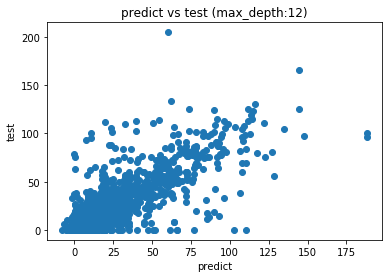

In [47]:
plt.scatter(predictions_df.prediction, predictions_df.SuicidePer100k)
plt.title("predict vs test (max_depth:12)")
plt.xlabel("predict")
plt.ylabel("test")
plt.show()